# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0710B1'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.PRFX_PREP = 'MelPrp0909B384' 
param.ARCH = 'efficientnet-b1'

from efficientnet_pytorch import EfficientNet
param.SZ = 384

param.EPOCHS = 15

param.BS = 56
param.SEED = 101; 

param.K=5; 
param.FLDS2USE = range(param.K)
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.USE_LAST_M_EPCS = 5

param.RandomResizedCrop_scale=(0.75, 1.0)
param.N_TTA = 8

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.EPOCHS = 15
#     param.FLDS2USE = [0,1]
    param.N_SAMPL = 1024

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0710B1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909B384',
 'ARCH': 'efficientnet-b1',
 'SZ': 384,
 'EPOCHS': 15,
 'BS': 56,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
!nvidia-smi

Sat Jul 11 03:12:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   58C    P0    63W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
if param.PRFX_B4 is not None: p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
23539,20,../output/MelPrp0909B384/siim-isic-melanoma-cl...,IP_2618037,0.0
48725,19,../output/MelPrp0909B384/andrewmvd--isic-2019/...,BCN_0000529,0.0


(58032, 4)

20    32701
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017767
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 46425 11607
1 46425 11607
2 46426 11606
3 46426 11606
4 46426 11606


0.0    0.912159
1.0    0.087841
Name: target, dtype: float64

0.0    0.911922
1.0    0.088078
Name: target, dtype: float64

0.0    0.911903
1.0    0.088097
Name: target, dtype: float64

0.0    0.910697
1.0    0.089303
Name: target, dtype: float64

0.0    0.913648
1.0    0.086352
Name: target, dtype: float64

20    26172
19    20253
Name: source, dtype: int64

20    26147
19    20278
Name: source, dtype: int64

20    26171
19    20255
Name: source, dtype: int64

20    26137
19    20289
Name: source, dtype: int64

20    26177
19    20249
Name: source, dtype: int64

In [7]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
19    25331
Name: source, dtype: int64

32701

In [8]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

11607 6529
11607 6554
11606 6530
11606 6564
11606 6524


## testset

In [9]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909B384/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909B384/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909B384/siim-isic-melanoma-cl...


# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if mode=='trn':
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
#                 A.Resize(param.SZ, param.SZ),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
#                 A.HueSaturationValue(
#                     hue_shift_limit=5,
#                     sat_shift_limit=5,
#                     p=1),
#                 A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
        else:
            self.composed = A.Compose([
                A.Resize(param.SZ, param.SZ),
                A.Normalize(),
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode in ('trn', 'val'):
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [11]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    dstrn = MelDataset(dftrn, mode='trn')
    i = np.random.choice(len(dstrn))
    print(dstrn[i][0].shape)
    plt.imshow(dstrn[i][0].permute(1, 2, 0))

## test ds

In [12]:
dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

10982
99


# model

In [13]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [14]:
# mdl = mkmdl()

## focal loss

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

# train

## TTA

In [16]:
# def evaluate(model, dl):
#     model.eval()
#     prd = []
#     y = []
#     for step, dat in enumerate(dl):
#         xb, yb = (o.to(device) for o in dat)
#         with torch.no_grad(): prdb = model(xb)
#         prd.append(prdb.cpu().detach().numpy())
#         y.append(yb.cpu().detach().numpy())
#     prd = np.concatenate(prd)    
#     y = np.concatenate(y)    
#     lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
#     scr = roc_auc(y, prd)
#     return lss, scr, y, prd

In [17]:
# Diheral TTA outside dataloader
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

In [18]:
def evaluate(model, dl):
    model.eval()
    prd = []
    y = []   
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        y.append(yb.cpu().detach().numpy())
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [19]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    

    return prd

## set up data

In [20]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    vl20 =fld2vl20[fld]
    assert set(vl20) < set(vl)
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    dfvl20=dftrn.iloc[vl20]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    ysvl20=dfvl20.target.values
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='val')
    dsvl20 = MelDataset(dfvl20, mode='val')
    dltr = DataLoader(dstr, batch_size=param.BS,       shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=param.BS*2,     shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl20 = DataLoader(dsvl20, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    lendl=len(dltr)    
    return dltr,dlvl,dlvl20

## run train

In [21]:
set_seed(param.SEED)

results = {}
results['fld2stats']={}
results['fld2trvl'] = fld2trvl
results['fld2vl20'] = fld2vl20
results['param'] = param

for fld in param.FLDS2USE:

    mdl = mkmdl().to(device)
    if param.PRFX_B4 is not None: 
        fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.fld}_best.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))
    # opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
    opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
    schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
    if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
    mdl.zero_grad()

        
    tr,vl=fld2trvl[fld]
    dltr,dlvl,dlvl20=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl,dlvl20:', len(dltr), len(dlvl),len(dlvl20))
    

    stats = {
    'lss': {'tr':[],'vl':[],'vl20':[]},
    'scr': {'tr':[],'vl':[],'vl20':[]},
    }
    ep2oof = []

    best_scr = float('-inf')
    best_epc = -1
    best_scr20 = float('-inf')
    best_epc20 = -1
    
    
    for epc in range(param.EPOCHS):
        prdtr_ep=[]
        ytr_ep=[]
        for step, dat in enumerate(dltr):
            mdl.train()
            xb,yb=(o.to(device) for o in dat)
            yb = yb.unsqueeze(1)
            prdb = mdl(xb)
    #         loss = F.binary_cross_entropy_with_logits(prdb, yb)
            loss =  loss_fn(prdb,yb)
            if param.FP16:
                with amp.scale_loss(loss, opt) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if param.FP16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
            else:
                torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
            opt.step()
            opt.zero_grad()
            prdtr_ep.append(prdb.cpu().detach().numpy())
            ytr_ep.append(yb.cpu().detach().numpy())
            if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{lendl}')

        prdtr_ep = np.concatenate(prdtr_ep)
        ytr_ep = np.concatenate(ytr_ep)    
        lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
        scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
        stats['lss']['tr'].append(lss_tr_ep)
        stats['scr']['tr'].append(scr_tr_ep)

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        lss_vl20_ep, scr_vl20_ep, yvl20_ep, prdvl20_ep = evaluate(mdl, dlvl20)
        stats['lss']['vl20'].append(lss_vl20_ep)
        stats['scr']['vl20'].append(scr_vl20_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; lss_vl20 {lss_vl20_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; scr_vl20 {scr_vl20_ep:.3f}; ')

        if epc> (5 if not param.DEBUG else -1):
            prdtst = infer(mdl, dltst)
            dfsub.target = sigmoid(prdtst)
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv', index=False)

        if scr_vl20_ep>best_scr20:
            print(f'better scr20 {best_scr20:.3f} -> {scr_vl20_ep:.3f}')
            best_scr20 = scr_vl20_ep
            best_epc20 = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best20.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best20.csv', index=False)

        schdl.step(scr_vl_ep)  # Update learning rate schedule
        
        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        stats['best_scr20'] = best_scr20
        stats['best_epc20'] = best_epc20
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'wb'))  

Loaded pretrained weights for efficientnet-b1
fld:0; dltr,dlvl,dlvl20: 830 104 59
2020-07-11 03:27:26 fld 0 ep 0: lss_tr 0.372; lss_vl 0.340; lss_vl20 0.245; scr_tr 0.851; scr_vl 0.894; scr_vl20 0.871; 
better scr -inf -> 0.894
better scr20 -inf -> 0.871
2020-07-11 03:42:01 fld 0 ep 1: lss_tr 0.351; lss_vl 0.287; lss_vl20 0.177; scr_tr 0.889; scr_vl 0.905; scr_vl20 0.874; 
better scr 0.894 -> 0.905
better scr20 0.871 -> 0.874
2020-07-11 03:57:25 fld 0 ep 2: lss_tr 0.342; lss_vl 0.343; lss_vl20 0.254; scr_tr 0.900; scr_vl 0.897; scr_vl20 0.883; 
better scr20 0.874 -> 0.883
2020-07-11 04:12:02 fld 0 ep 3: lss_tr 0.339; lss_vl 0.276; lss_vl20 0.156; scr_tr 0.908; scr_vl 0.914; scr_vl20 0.886; 
better scr 0.905 -> 0.914
better scr20 0.883 -> 0.886
2020-07-11 04:27:26 fld 0 ep 4: lss_tr 0.335; lss_vl 0.296; lss_vl20 0.207; scr_tr 0.912; scr_vl 0.916; scr_vl20 0.899; 
better scr 0.914 -> 0.916
better scr20 0.886 -> 0.899
2020-07-11 04:42:00 fld 0 ep 5: lss_tr 0.330; lss_vl 0.318; lss_vl20 0.

2020-07-11 16:57:10 fld 3 ep 7: lss_tr 0.318; lss_vl 0.307; lss_vl20 0.218; scr_tr 0.925; scr_vl 0.904; scr_vl20 0.852; 
2020-07-11 17:11:47 fld 3 ep 8: lss_tr 0.308; lss_vl 0.266; lss_vl20 0.173; scr_tr 0.930; scr_vl 0.909; scr_vl20 0.868; 
2020-07-11 17:26:54 fld 3 ep 9: lss_tr 0.306; lss_vl 0.327; lss_vl20 0.237; scr_tr 0.935; scr_vl 0.910; scr_vl20 0.872; 
2020-07-11 17:42:02 fld 3 ep 10: lss_tr 0.308; lss_vl 0.292; lss_vl20 0.196; scr_tr 0.934; scr_vl 0.913; scr_vl20 0.868; 
better scr 0.911 -> 0.913
2020-07-11 17:57:11 fld 3 ep 11: lss_tr 0.295; lss_vl 0.297; lss_vl20 0.190; scr_tr 0.941; scr_vl 0.909; scr_vl20 0.878; 
2020-07-11 17:57:13 step 0/99
2020-07-11 18:11:48 fld 3 ep 12: lss_tr 0.292; lss_vl 0.259; lss_vl20 0.161; scr_tr 0.943; scr_vl 0.922; scr_vl20 0.887; 
2020-07-11 18:11:50 step 0/99
better scr 0.913 -> 0.922
2020-07-11 18:26:11 fld 3 ep 13: lss_tr 0.286; lss_vl 0.294; lss_vl20 0.203; scr_tr 0.946; scr_vl 0.916; scr_vl20 0.879; 
2020-07-11 18:26:12 step 0/99
2020-07

In [22]:
pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  

# training trajec

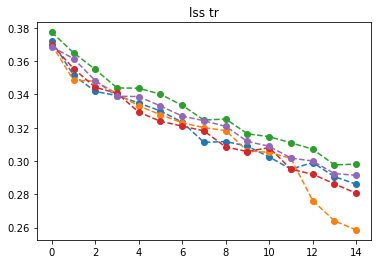

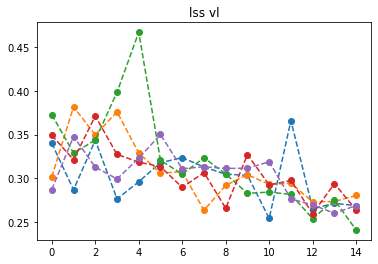

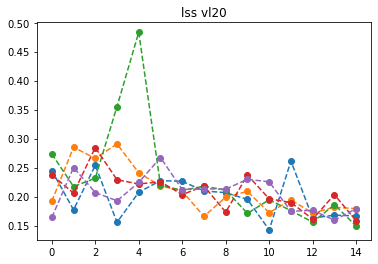

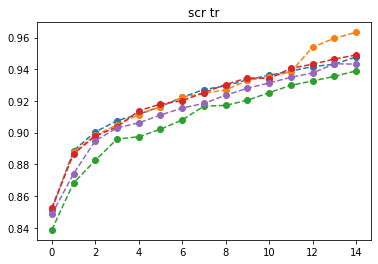

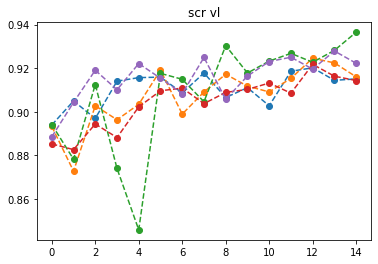

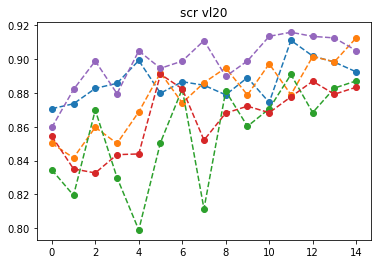

In [23]:
for mtrc in ['lss', 'scr']:
    for k in ['tr','vl','vl20']:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [24]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(58032, [0, 13, 16, 19, 27, 29, 31, 54, 55, 60])

## only last epoch

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.9177082594130449

## only best_scr epoch

In [26]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9237253232210139

## avg all epochs

In [27]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof.mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9291397806001227

## avg last m epochs

In [28]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9278857889138048

In [29]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [30]:
for m in range(1, 5):
    oofs = get_oof_avg_last_m(m)
    print(m, roc_auc(dftrn.target.iloc[vls], oofs))

1 0.9177082594130449
2 0.925056616855134
3 0.9278857889138048
4 0.929226001576243


## avg last m epochs before epo-q

In [31]:
def get_oof_avg_last_m_before_q(m,q):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, q-m:q].mean(1))
        oofs += list(oof)
    return oofs

In [32]:
for m in range(1, 5):
    oofs = get_oof_avg_last_m_before_q(m, 10)
    print(m, roc_auc(dftrn.target.iloc[vls], oofs))

1 0.9120224380982505
2 0.9219539686541953
3 0.9222135608794046
4 0.9240424633568349


# submissions

## only last epoch

In [33]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{param.EPOCHS-1}.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.1469974972723544


,image_name,target
0,ISIC_0052060,0.062445
1,ISIC_0052349,0.054702
2,ISIC_0058510,0.068787


fld 1 0.17088818017137034


,image_name,target
0,ISIC_0052060,0.064065
1,ISIC_0052349,0.043691
2,ISIC_0058510,0.040846


fld 2 0.14004493783909977


,image_name,target
0,ISIC_0052060,0.057705
1,ISIC_0052349,0.039269
2,ISIC_0058510,0.081520


fld 3 0.14662291164660213


,image_name,target
0,ISIC_0052060,0.049314
1,ISIC_0052349,0.048677
2,ISIC_0058510,0.054500


fld 4 0.1598023659228736


,image_name,target
0,ISIC_0052060,0.103567
1,ISIC_0052349,0.090253
2,ISIC_0058510,0.113580


0.15287117857046076


,image_name,target
0,ISIC_0052060,0.067419
1,ISIC_0052349,0.055318
2,ISIC_0058510,0.071846


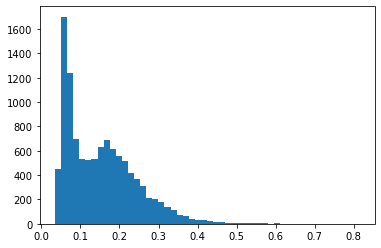

In [34]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [35]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlylast.csv', index=False)

## only best_scr epoch

In [36]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.15839839345464338


,image_name,target
0,ISIC_0052060,0.047958
1,ISIC_0052349,0.050331
2,ISIC_0058510,0.039195


fld 1 0.15779989961118232


,image_name,target
0,ISIC_0052060,0.093017
1,ISIC_0052349,0.074635
2,ISIC_0058510,0.056548


fld 2 0.14004493783909977


,image_name,target
0,ISIC_0052060,0.057705
1,ISIC_0052349,0.039269
2,ISIC_0058510,0.081520


fld 3 0.15184717111955912


,image_name,target
0,ISIC_0052060,0.071332
1,ISIC_0052349,0.058993
2,ISIC_0058510,0.058885


fld 4 0.14772039074831575


,image_name,target
0,ISIC_0052060,0.078926
1,ISIC_0052349,0.076546
2,ISIC_0058510,0.060087


0.15116215855456017


,image_name,target
0,ISIC_0052060,0.069788
1,ISIC_0052349,0.059955
2,ISIC_0058510,0.059247


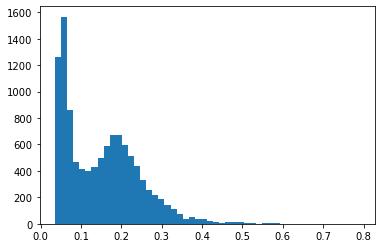

In [37]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [38]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr.csv', index=False)

## avg last m epochs

In [57]:
m = 4 #3#2

In [58]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-m, param.EPOCHS):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 11 0.2538542256742834


,image_name,target
0,ISIC_0052060,0.079639
1,ISIC_0052349,0.090574
2,ISIC_0058510,0.172033


fld 0 epc 12 0.15839839345464338


,image_name,target
0,ISIC_0052060,0.047958
1,ISIC_0052349,0.050331
2,ISIC_0058510,0.039195


fld 0 epc 13 0.16331316855515335


,image_name,target
0,ISIC_0052060,0.040999
1,ISIC_0052349,0.038538
2,ISIC_0058510,0.108566


fld 0 epc 14 0.1469974972723544


,image_name,target
0,ISIC_0052060,0.062445
1,ISIC_0052349,0.054702
2,ISIC_0058510,0.068787


fld 1 epc 11 0.18409649841395034


,image_name,target
0,ISIC_0052060,0.114369
1,ISIC_0052349,0.062674
2,ISIC_0058510,0.071203


fld 1 epc 12 0.15779989961118232


,image_name,target
0,ISIC_0052060,0.093017
1,ISIC_0052349,0.074635
2,ISIC_0058510,0.056548


fld 1 epc 13 0.1663374575818612


,image_name,target
0,ISIC_0052060,0.110663
1,ISIC_0052349,0.109897
2,ISIC_0058510,0.072112


fld 1 epc 14 0.17088818017137034


,image_name,target
0,ISIC_0052060,0.064065
1,ISIC_0052349,0.043691
2,ISIC_0058510,0.040846


fld 2 epc 11 0.17268570173930034


,image_name,target
0,ISIC_0052060,0.055926
1,ISIC_0052349,0.069038
2,ISIC_0058510,0.082994


fld 2 epc 12 0.13981622043261716


,image_name,target
0,ISIC_0052060,0.053108
1,ISIC_0052349,0.073696
2,ISIC_0058510,0.055720


fld 2 epc 13 0.1715195014512835


,image_name,target
0,ISIC_0052060,0.085709
1,ISIC_0052349,0.079353
2,ISIC_0058510,0.074635


fld 2 epc 14 0.14004493783909977


,image_name,target
0,ISIC_0052060,0.057705
1,ISIC_0052349,0.039269
2,ISIC_0058510,0.081520


fld 3 epc 11 0.18287219949189665


,image_name,target
0,ISIC_0052060,0.070049
1,ISIC_0052349,0.092688
2,ISIC_0058510,0.062331


fld 3 epc 12 0.15184717111955912


,image_name,target
0,ISIC_0052060,0.071332
1,ISIC_0052349,0.058993
2,ISIC_0058510,0.058885


fld 3 epc 13 0.1784047855977947


,image_name,target
0,ISIC_0052060,0.087252
1,ISIC_0052349,0.051750
2,ISIC_0058510,0.076270


fld 3 epc 14 0.14662291164660213


,image_name,target
0,ISIC_0052060,0.049314
1,ISIC_0052349,0.048677
2,ISIC_0058510,0.054500


fld 4 epc 11 0.16742996552399295


,image_name,target
0,ISIC_0052060,0.083292
1,ISIC_0052349,0.033024
2,ISIC_0058510,0.084795


fld 4 epc 12 0.1623805071867594


,image_name,target
0,ISIC_0052060,0.092033
1,ISIC_0052349,0.082549
2,ISIC_0058510,0.090897


fld 4 epc 13 0.14772039074831575


,image_name,target
0,ISIC_0052060,0.078926
1,ISIC_0052349,0.076546
2,ISIC_0058510,0.060087


fld 4 epc 14 0.1598023659228736


,image_name,target
0,ISIC_0052060,0.103567
1,ISIC_0052349,0.090253
2,ISIC_0058510,0.113580


0.16614159897174513


,image_name,target
0,ISIC_0052060,0.075068
1,ISIC_0052349,0.066044
2,ISIC_0058510,0.076275


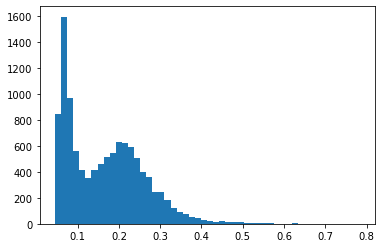

In [59]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [60]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

## avg last m epochs before epo-q

In [49]:
m = 2
q = 14

In [50]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(q-m, q):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 12 0.15839839345464338


,image_name,target
0,ISIC_0052060,0.047958
1,ISIC_0052349,0.050331
2,ISIC_0058510,0.039195


fld 0 epc 13 0.16331316855515335


,image_name,target
0,ISIC_0052060,0.040999
1,ISIC_0052349,0.038538
2,ISIC_0058510,0.108566


fld 1 epc 12 0.15779989961118232


,image_name,target
0,ISIC_0052060,0.093017
1,ISIC_0052349,0.074635
2,ISIC_0058510,0.056548


fld 1 epc 13 0.1663374575818612


,image_name,target
0,ISIC_0052060,0.110663
1,ISIC_0052349,0.109897
2,ISIC_0058510,0.072112


fld 2 epc 12 0.13981622043261716


,image_name,target
0,ISIC_0052060,0.053108
1,ISIC_0052349,0.073696
2,ISIC_0058510,0.055720


fld 2 epc 13 0.1715195014512835


,image_name,target
0,ISIC_0052060,0.085709
1,ISIC_0052349,0.079353
2,ISIC_0058510,0.074635


fld 3 epc 12 0.15184717111955912


,image_name,target
0,ISIC_0052060,0.071332
1,ISIC_0052349,0.058993
2,ISIC_0058510,0.058885


fld 3 epc 13 0.1784047855977947


,image_name,target
0,ISIC_0052060,0.087252
1,ISIC_0052349,0.051750
2,ISIC_0058510,0.076270


fld 4 epc 12 0.1623805071867594


,image_name,target
0,ISIC_0052060,0.092033
1,ISIC_0052349,0.082549
2,ISIC_0058510,0.090897


fld 4 epc 13 0.14772039074831575


,image_name,target
0,ISIC_0052060,0.078926
1,ISIC_0052349,0.076546
2,ISIC_0058510,0.060087


0.1597537495739173


,image_name,target
0,ISIC_0052060,0.076100
1,ISIC_0052349,0.069629
2,ISIC_0058510,0.069292


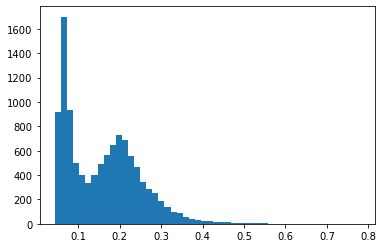

In [51]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [52]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_{m}before{q}.csv', index=False)

# fin

In [61]:
param.__dict__

{'PRFX': 'Mel0710B1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909B384',
 'ARCH': 'efficientnet-b1',
 'SZ': 384,
 'EPOCHS': 15,
 'BS': 56,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [62]:
!nvidia-smi

Sun Jul 12 00:41:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   49C    P0   157W / 300W |  15783MiB / 16160MiB |     25%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  